In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive


Mounted at /gdrive
/gdrive


In [2]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 52 kB/s 
     |████████████████████████████████| 199 kB 64.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=52d255f026d1db5be3ff7f2d3520f9067e39cc336cad380db82243f6482099ec
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


In [3]:
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import *


In [4]:
spark = SparkSession.Builder().getOrCreate()

In [5]:
data = spark.read.csv('/gdrive/MyDrive/drug200 (1).csv',header = True,inferSchema=True)


In [6]:
data.show()

+---+---+------+-----------+-------+-----+
|Age|Sex|    BP|Cholesterol|Na_to_K| Drug|
+---+---+------+-----------+-------+-----+
| 23|  F|  HIGH|       HIGH| 25.355|drugY|
| 47|  M|   LOW|       HIGH| 13.093|drugC|
| 47|  M|   LOW|       HIGH| 10.114|drugC|
| 28|  F|NORMAL|       HIGH|  7.798|drugX|
| 61|  F|   LOW|       HIGH| 18.043|drugY|
| 22|  F|NORMAL|       HIGH|  8.607|drugX|
| 49|  F|NORMAL|       HIGH| 16.275|drugY|
| 41|  M|   LOW|       HIGH| 11.037|drugC|
| 60|  M|NORMAL|       HIGH| 15.171|drugY|
| 43|  M|   LOW|     NORMAL| 19.368|drugY|
| 47|  F|   LOW|       HIGH| 11.767|drugC|
| 34|  F|  HIGH|     NORMAL| 19.199|drugY|
| 43|  M|   LOW|       HIGH| 15.376|drugY|
| 74|  F|   LOW|       HIGH| 20.942|drugY|
| 50|  F|NORMAL|       HIGH| 12.703|drugX|
| 16|  F|  HIGH|     NORMAL| 15.516|drugY|
| 69|  M|   LOW|     NORMAL| 11.455|drugX|
| 43|  M|  HIGH|       HIGH| 13.972|drugA|
| 23|  M|   LOW|       HIGH|  7.298|drugC|
| 32|  F|  HIGH|     NORMAL| 25.974|drugY|
+---+---+--

In [7]:
data.limit(5).show()

+---+---+------+-----------+-------+-----+
|Age|Sex|    BP|Cholesterol|Na_to_K| Drug|
+---+---+------+-----------+-------+-----+
| 23|  F|  HIGH|       HIGH| 25.355|drugY|
| 47|  M|   LOW|       HIGH| 13.093|drugC|
| 47|  M|   LOW|       HIGH| 10.114|drugC|
| 28|  F|NORMAL|       HIGH|  7.798|drugX|
| 61|  F|   LOW|       HIGH| 18.043|drugY|
+---+---+------+-----------+-------+-----+



In [8]:
data.limit(5).toPandas()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [9]:
data = data.na.drop(how='any')
# create a new column where purchase frequency >=0.5 - > 1 and rest all termed as 0 
data = data.withColumn("Label",data.Drug)
# casting of the label into string
data = data.withColumn("Label",data["Label"].cast("String"))
print(data.show())

# string indexer 
from pyspark.ml.feature import StringIndexer
index = StringIndexer(inputCol = "Label",outputCol = "Target")
train = index.fit(data).transform(data)

train.show(

+---+---+------+-----------+-------+-----+-----+
|Age|Sex|    BP|Cholesterol|Na_to_K| Drug|Label|
+---+---+------+-----------+-------+-----+-----+
| 23|  F|  HIGH|       HIGH| 25.355|drugY|drugY|
| 47|  M|   LOW|       HIGH| 13.093|drugC|drugC|
| 47|  M|   LOW|       HIGH| 10.114|drugC|drugC|
| 28|  F|NORMAL|       HIGH|  7.798|drugX|drugX|
| 61|  F|   LOW|       HIGH| 18.043|drugY|drugY|
| 22|  F|NORMAL|       HIGH|  8.607|drugX|drugX|
| 49|  F|NORMAL|       HIGH| 16.275|drugY|drugY|
| 41|  M|   LOW|       HIGH| 11.037|drugC|drugC|
| 60|  M|NORMAL|       HIGH| 15.171|drugY|drugY|
| 43|  M|   LOW|     NORMAL| 19.368|drugY|drugY|
| 47|  F|   LOW|       HIGH| 11.767|drugC|drugC|
| 34|  F|  HIGH|     NORMAL| 19.199|drugY|drugY|
| 43|  M|   LOW|       HIGH| 15.376|drugY|drugY|
| 74|  F|   LOW|       HIGH| 20.942|drugY|drugY|
| 50|  F|NORMAL|       HIGH| 12.703|drugX|drugX|
| 16|  F|  HIGH|     NORMAL| 15.516|drugY|drugY|
| 69|  M|   LOW|     NORMAL| 11.455|drugX|drugX|
| 43|  M|  HIGH|    

In [10]:
from pyspark.ml.feature import VectorAssembler
VecAssemble = VectorAssembler(inputCols=['Age','Na_to_K'],outputCol='Features')
feat_data = VecAssemble.transform(train)

feat_data = feat_data.select('Features','Target')
print(feat_data.show(10))

+-------------+------+
|     Features|Target|
+-------------+------+
|[23.0,25.355]|   0.0|
|[47.0,13.093]|   4.0|
|[47.0,10.114]|   4.0|
| [28.0,7.798]|   1.0|
|[61.0,18.043]|   0.0|
| [22.0,8.607]|   1.0|
|[49.0,16.275]|   0.0|
|[41.0,11.037]|   4.0|
|[60.0,15.171]|   0.0|
|[43.0,19.368]|   0.0|
+-------------+------+
only showing top 10 rows

None


In [11]:
#split the data 
ratio = [0.8,0.2]
TrainData,TestData = feat_data.randomSplit(ratio,2)
TrainData.show(10)

+-------------+------+
|     Features|Target|
+-------------+------+
| [15.0,9.084]|   1.0|
|[15.0,16.725]|   0.0|
|[15.0,17.206]|   0.0|
|[16.0,12.006]|   4.0|
|[16.0,19.007]|   0.0|
|[17.0,10.832]|   1.0|
|  [18.0,8.75]|   1.0|
|[18.0,24.276]|   0.0|
|[18.0,37.188]|   0.0|
|[19.0,13.313]|   2.0|
+-------------+------+
only showing top 10 rows



In [12]:
from pyspark.ml.classification import LogisticRegression
lrModel = LogisticRegression(featuresCol='Features',labelCol='Target',maxIter=20)
lrModel = lrModel.fit(TrainData)
history = lrModel.summary
print(history.accuracy)

0.7261146496815286


In [13]:
op = lrModel.transform(TestData)
op.show(15)

+-------------+------+--------------------+--------------------+----------+
|     Features|Target|       rawPrediction|         probability|prediction|
+-------------+------+--------------------+--------------------+----------+
|[16.0,15.516]|   0.0|[8.37596806732374...|[0.99948491180358...|       0.0|
|[20.0,11.686]|   1.0|[-14.351950391796...|[1.18829521296266...|       1.0|
| [23.0,16.85]|   0.0|[15.8188191627427...|[0.99999996419656...|       0.0|
| [24.0,9.475]|   2.0|[-27.567786365034...|[9.20036905447723...|       1.0|
|[24.0,25.786]|   0.0|[68.2639476851254...|[1.0,2.9041391964...|       0.0|
| [26.0,14.16]|   4.0|[-0.1548806120027...|[0.06945306334094...|       2.0|
|[28.0,13.127]|   4.0|[-6.3368406120708...|[3.63003641121835...|       1.0|
|[28.0,18.809]|   0.0|[27.0465149683969...|[0.99999999999997...|       0.0|
|[29.0,12.856]|   2.0|[-7.9854387404039...|[4.82058658607914...|       1.0|
| [32.0,7.477]|   1.0|[-39.757773354269...|[2.72389825103646...|       1.0|
|[33.0,33.48

In [15]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [18]:
eval = MulticlassClassificationEvaluator(labelCol = 'Target',predictionCol='prediction')
print("Testing Accuracy: ", eval.evaluate(op))


Testing Accuracy:  0.6760797342192691


In [19]:
from pyspark.ml.classification import RandomForestClassifier

In [20]:

rfmodel = RandomForestClassifier(featuresCol='Features',labelCol = 'Target')


In [22]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

paramGrid = ParamGridBuilder().addGrid(rfmodel.numTrees,[100,200,300])\
            .addGrid(rfmodel.maxDepth,[2,3,4,7])\
            .addGrid(rfmodel.impurity,["entropy","gini"]).build()

    

In [23]:
eva11 =  MulticlassClassificationEvaluator(labelCol="Target", predictionCol="prediction")

crossval = CrossValidator(estimator = rfmodel,
                          estimatorParamMaps=paramGrid,
                          evaluator=eva11,
                          numFolds=5)

In [25]:
finalModel = crossval.fit(TrainData)
print(finalModel)

CrossValidatorModel_cefbed69d70d


In [26]:
predictions = finalModel.transform(TestData)

In [27]:
print(predictions.show())

+-------------+------+--------------------+--------------------+----------+
|     Features|Target|       rawPrediction|         probability|prediction|
+-------------+------+--------------------+--------------------+----------+
|[16.0,15.516]|   0.0|[200.0,0.0,0.0,0....|[1.0,0.0,0.0,0.0,...|       0.0|
|[20.0,11.686]|   1.0|[0.0,69.943071167...|[0.0,0.3497153558...|       2.0|
| [23.0,16.85]|   0.0|[200.0,0.0,0.0,0....|[1.0,0.0,0.0,0.0,...|       0.0|
| [24.0,9.475]|   2.0|[0.0,133.86618961...|[0.0,0.6693309480...|       1.0|
|[24.0,25.786]|   0.0|[200.0,0.0,0.0,0....|[1.0,0.0,0.0,0.0,...|       0.0|
| [26.0,14.16]|   4.0|[20.0,118.7440664...|[0.1,0.5937203323...|       1.0|
|[28.0,13.127]|   4.0|[0.0,111.44013776...|[0.0,0.5572006888...|       1.0|
|[28.0,18.809]|   0.0|[200.0,0.0,0.0,0....|[1.0,0.0,0.0,0.0,...|       0.0|
|[29.0,12.856]|   2.0|[0.0,121.66632824...|[0.0,0.6083316412...|       1.0|
| [32.0,7.477]|   1.0|[0.0,130.70190386...|[0.0,0.6535095193...|       1.0|
|[33.0,33.48

In [29]:
eval2 =  MulticlassClassificationEvaluator(labelCol='Target',predictionCol='prediction')
eval2.evaluate(predictions)

0.6186046511627906

In [70]:
#model = ['decision tree','svm','random forest']

In [30]:
import pandas as pd
import numpy as np


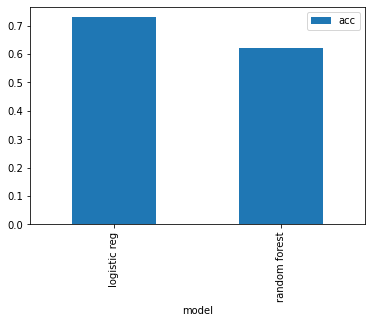

In [32]:
df = pd.DataFrame({'model': ['logistic reg', 'random forest'], 'acc': [0.73,0.62]})
df.plot.bar(x='model', y='acc')